In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy import text

In [2]:
engine = create_engine("sqlite:///../data/news.db")

In [3]:
conn = engine.connect()

---

We can check how many articles there are for each publication.

Most articles are from Reuters.

In [4]:
query = "SELECT publication, COUNT(*) AS num FROM articles GROUP BY publication ORDER BY num DESC"

results = conn.execute(text(query))

df_pub = pd.DataFrame(results.fetchall(), columns = results.keys())

In [5]:
df_pub.head()

,publication,num
0,Reuters,840094
1,The New York Times,252259
2,CNBC,238096
3,The Hill,208411
4,People,136488


---

We can check how many articles there are for each section.

There are over 900k unsorted. The majority are in the sections we would expect, e.g., world news, politics, etc.

Importantly we see that there are 2 politics sections that appear with different casing "politics" and "Politics".

In [6]:
query = "SELECT section, COUNT(*) AS num FROM articles GROUP BY section ORDER BY num DESC"

results = conn.execute(text(query))

df_sec = pd.DataFrame(results.fetchall(), columns = results.keys())

In [7]:
df_sec.head(20)

,section,num
0,,912273
1,Market News,108724
2,World News,108651
3,Business News,96395
4,Wires,67352
5,Financials,57845
6,politics,53496
7,us,51242
8,Intel,39805
9,Bonds News,39672


---

Since we are interested in the politics articles, we can check which sections contain the string "politic", this will match "politics", "political", etc.

As we saw before, we will have to check for case-insensitive matches.

Most of them are in "politics" or "Politics" as expected but there are also smaller section for different countries as well as many other sections that seem to be connected with a specific article.

In [8]:
df_sec[df_sec.section.str.contains("politic", case=False)].head(20)

,section,num
6,politics,53496
10,Politics,33875
231,World Politics,702
274,Europe Politics,438
292,Asia Politics,363
321,POLITICS,251
334,China Politics,231
386,Opinion - Politics,143
516,Political,62
1141,Political Leaders,8


---

We can check which years the articles are from.

The years range from 2016 - 2020.

In [9]:
#query = "SELECT strftime('%Y', date) AS yr, COUNT(*) AS num FROM articles GROUP BY yr"
query = "SELECT year, COUNT(*) AS num FROM articles GROUP BY year"

results = conn.execute(text(query))

df_year = pd.DataFrame(results.fetchall(), columns = results.keys())

In [10]:
df_year

,year,num
0,2016,604511
1,2017,640493
2,2018,553588
3,2019,655456
4,2020,234830


---

We can check how many articles are political articles for each year by going through the above politics sections. We can focus only on the sections with more than 10 articles.

There are only 5k politics article in 2020.

In [11]:
politics_sec = df_sec[df_sec.section.str.contains("politic", case=False)]
politics_sec.reset_index(drop=True, inplace=True)
politics_sec = politics_sec[politics_sec["num"] > 10]

In [12]:
df_politics_year = None

query = "SELECT year, COUNT(*) AS num FROM articles WHERE section = :sec GROUP BY year"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_year = pd.concat([df_politics_year, temp_df])

df_politics_year = df_politics_year.groupby("year").sum()

In [13]:
df_politics_year

,num
year,
2016,14906
2017,23651
2018,23607
2019,21841
2020,5556


---

# 2016

Let's explore all the politics articles from 2016

In [14]:
df_politics_2016 = None

query = "SELECT * FROM articles WHERE year = 2016 AND section = :sec"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_2016 = pd.concat([df_politics_2016, temp_df])
conn.close()

In [15]:
df_politics_2016

,id,date,year,month,day,author,title,article,url,section,publication
0,28115,2016-02-02 18:05:00,2016,2,2,Osman Faruqi,Australian Politics Has a Sexual Harassment Pr...,This article originally appeared on VICE Austr...,https://www.vice.com/en_us/article/nn9yxz/all-...,politics,Vice
1,51350,2016-12-27 15:03:00,2016,12,27,Tshepo Mokoena,Why Authoritarianism Refuses to Die,"There's a fascist in every one of us. Yeah, y...",https://www.vice.com/en_us/article/ypve8y/what...,politics,Vice
2,56242,2016-12-13 16:00:00,2016,12,13,Matthew Goodwin,Populists May Seize Even More Power in 2017,This post originally appeared on VICE UK. For ...,https://www.vice.com/en_us/article/pgpmdk/popu...,politics,Vice
3,58574,2016-12-23 15:20:00,2016,12,23,Jessi Phillips,How to Run for Office with No Money and Little...,Matt Hummel wasn't a complete political novice...,https://www.vice.com/en_us/article/4xw8mj/how-...,politics,Vice
4,99446,2016-12-12 21:45:00,2016,12,12,Harry Cheadle,America Is Not Prepared for President @RealDon...,"Most mornings these days, I wake up, check the...",https://www.vice.com/en_us/article/78be99/amer...,politics,Vice
...,...,...,...,...,...,...,...,...,...,...,...
4768,1624288,2016-10-20,2016,10,20,,Voters illegally removed from Ohio rolls may c...,(Reuters) - A federal judge in Ohio laid out a...,http://www.reuters.com/article/us-election-ohi...,Politics,Reuters
4769,1624295,2016-05-20,2016,5,20,,"NRA, the top U.S. gun lobby group, endorses Tr...",WASHINGTON (Reuters) - The National Rifle Asso...,http://www.reuters.com/article/us-usa-election...,Politics,Reuters
4770,1624447,2016-10-15,2016,10,15,Steve Holland,How Trump rallies the faithful: Belittle Clint...,"CHARLOTTE, N.C. (Reuters) - Republican preside...",http://www.reuters.com/article/us-usa-election...,Politics,Reuters
4771,1624867,2016-11-15,2016,11,15,Bill Trott,Bannon role in Trump administration sets off c...,WASHINGTON (Reuters) - White supremacists and ...,http://www.reuters.com/article/us-usa-trump-ba...,Politics,Reuters


---

 Most of them are from CNN

In [16]:
df_politics_2016.publication.value_counts()

CNN          9347
Reuters      3412
CNBC         1359
People        778
Vice            8
The Verge       2
Name: publication, dtype: int64

---

There are a few articles that are empty and will need to be dropped.

In [17]:
(df_politics_2016.article == "").value_counts()

False    14899
True         7
Name: article, dtype: int64

In [18]:
articles_to_drop = df_politics_2016[df_politics_2016.article == ""]
articles_to_drop

,id,date,year,month,day,author,title,article,url,section,publication
3638,853707,2016-04-17 00:00:00,2016,4,17,,Error,,https://www.cnn.com/2016/04/17/politics/hillar...,politics,CNN
3742,854456,2016-04-21 00:00:00,2016,4,21,,Error,,https://www.cnn.com/2016/04/21/politics/f22-ra...,politics,CNN
3872,855363,2016-04-27 00:00:00,2016,4,27,,Error,,https://www.cnn.com/2016/04/27/politics/obama-...,politics,CNN
4060,856497,2016-05-05 00:00:00,2016,5,5,,Error,,https://www.cnn.com/2016/05/05/politics/donald...,politics,CNN
4343,858315,2016-05-18 00:00:00,2016,5,18,,Error,,https://www.cnn.com/2016/05/18/politics/ed-ren...,politics,CNN
5373,864487,2016-07-03 00:00:00,2016,7,3,,Error,,https://www.cnn.com/2016/07/03/politics/failed...,politics,CNN
10032,891040,2016-12-13 00:00:00,2016,12,13,,All the President’s tweets,,https://www.cnn.com/2016/12/13/politics/donald...,politics,CNN


In [19]:
df_politics_2016.drop(articles_to_drop.index, inplace=True)
df_politics_2016.reset_index(drop=True, inplace=True)
(df_politics_2016.article == "").value_counts()

False    14894
Name: article, dtype: int64

---

There are also articles that only contain a space and will need to be dropped.

In [20]:
(df_politics_2016.article == " ").value_counts()

False    14818
True        76
Name: article, dtype: int64

In [21]:
articles_to_drop = df_politics_2016[df_politics_2016.article == " "]
articles_to_drop.head()

,id,date,year,month,day,author,title,article,url,section,publication
861,835366,2016-01-07 00:00:00,2016,1,7,,Full results: CNN/ORC poll on guns in America,,https://www.cnn.com/2016/01/07/politics/obama-...,politics,CNN
1198,837515,2016-01-19 00:00:00,2016,1,19,,CNN/WMUR poll full results: New Hampshire Demo...,,https://www.cnn.com/2016/01/19/politics/new-ha...,politics,CNN
1234,837741,2016-01-20 00:00:00,2016,1,20,,New Hampshire CNN/WMUR poll results: Republicans,,https://www.cnn.com/2016/01/20/politics/new-ha...,politics,CNN
1254,837836,2016-01-20 00:00:00,2016,1,20,,CNN/WMUR poll full results: General election m...,,https://www.cnn.com/2016/01/20/politics/new-ha...,politics,CNN
1288,837995,2016-01-21 00:00:00,2016,1,21,,Iowa CNN/ORC poll: Full results,,https://www.cnn.com/2016/01/21/politics/iowa-p...,politics,CNN


In [22]:
df_politics_2016.drop(articles_to_drop.index, inplace=True)
df_politics_2016.reset_index(drop=True, inplace=True)
(df_politics_2016.article == " ").value_counts()

False    14818
Name: article, dtype: int64

---

Most articles are about the same length but there are a few extremely long ones and extremely short.

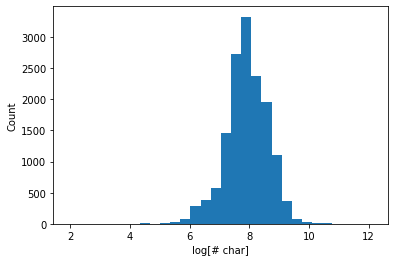

In [23]:
plt.xlabel("log[# char]")
plt.ylabel("Count")

plt.hist(np.log(df_politics_2016.article.str.len()), bins=30);

In [24]:
article_lengths = df_politics_2016.article.str.len().sort_values()
article_lengths

1724          7
2789          7
7586         11
8083         17
5833         19
          ...  
14045     67268
4087      71018
1687     107383
2792     124836
3524     188526
Name: article, Length: 14818, dtype: int64

---

The long ones seem to correspond to debate transcripts.

In [25]:
df_politics_2016.iloc[article_lengths.index[-5:]]

,id,date,year,month,day,author,title,article,url,section,publication
14045,1418207,2016-11-28,2016,11,28,,The 141 Stances Donald Trump Took During His W...,President-Elect Donald Trump took 141 distinct...,https://www.cnbc.com/2016/11/28/the-141-stance...,Politics,CNBC
4087,857099,2016-05-10 00:00:00,2016,5,10,,Transcript: Jon Stewart finally weighs in on 2...,"The Axe Files, featuring David Axelrod, is a p...",https://www.cnn.com/2016/05/10/politics/jon-st...,politics,CNN
1687,840694,2016-02-03 00:00:00,2016,2,3,,"Democratic town hall: Transcript, video",Transcript of the CNN Democratic Town Hall in ...,https://www.cnn.com/2016/02/03/politics/democr...,politics,CNN
2792,847839,2016-03-10 00:00:00,2016,3,10,,"Transcript of Republican debate in Miami, full...",(CNN)TAPPER: Live from the Bank United Center...,https://www.cnn.com/2016/03/10/politics/republ...,politics,CNN
3524,853237,2016-04-14 00:00:00,2016,4,14,,Full transcript: CNN Democratic debate in New ...,(CNN)The full transcript from the CNN Democra...,https://www.cnn.com/2016/04/14/politics/transc...,politics,CNN


---

The short ones seem to be corrupted.

In [26]:
df_politics_2016.iloc[article_lengths.index[:5]]

,id,date,year,month,day,author,title,article,url,section,publication
1724,840916,2016-02-04 00:00:00,2016,2,4,,CNN/WMUR New Hampshire GOP poll: Full results,(CNN),https://www.cnn.com/2016/02/04/politics/gop-ne...,politics,CNN
2789,847823,2016-03-10 00:00:00,2016,3,10,Tal Kopan,Republican debate: Live updates,(CNN),https://www.cnn.com/2016/03/10/politics/republ...,politics,CNN
7586,878359,2016-10-05 00:00:00,2016,10,5,David Wright,Vice presidential debate: The number of times ...,(CNN)23.,https://www.cnn.com/2016/10/05/politics/elaine...,politics,CNN
8083,881052,2016-10-19 00:00:00,2016,10,19,Tal Kopan,"Presidential debate live updates, live stream",Washington (CNN),https://www.cnn.com/2016/10/19/politics/debate...,politics,CNN
5833,867541,2016-07-25 00:00:00,2016,7,25,Tal Kopan,DNC live updates,Philadelphia (CNN),https://www.cnn.com/2016/07/25/politics/dnc-li...,politics,CNN


---

Based on the above distribution of article lengths, we can assume that articles with $\le e^6$ characters ($\approx 80$ words) are likely corrupted or too short and will be dropped.

In [27]:
df_politics_2016 = df_politics_2016[df_politics_2016.article.str.len() > int(np.exp(6))]
df_politics_2016.reset_index(drop=True, inplace=True)

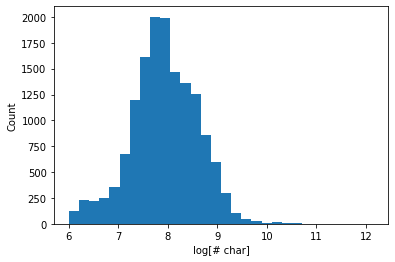

In [28]:
plt.xlabel("log[# char]")
plt.ylabel("Count")

plt.hist(np.log(df_politics_2016.article.str.len()), bins=30);

---

The final number of articles is 14705

In [29]:
len(df_politics_2016)

14705

---

Finally, it's important that all the words are lowercase so they can be matched to stop words and with each other.

In [30]:
df_politics_2016.article = df_politics_2016.article.str.lower()
df_politics_2016.head()

/tmp/ipykernel_1068/2511584571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_politics_2016.article = df_politics_2016.article.str.lower()


,id,date,year,month,day,author,title,article,url,section,publication
0,28115,2016-02-02 18:05:00,2016,2,2,Osman Faruqi,Australian Politics Has a Sexual Harassment Pr...,this article originally appeared on vice austr...,https://www.vice.com/en_us/article/nn9yxz/all-...,politics,Vice
1,51350,2016-12-27 15:03:00,2016,12,27,Tshepo Mokoena,Why Authoritarianism Refuses to Die,"there's a fascist in every one of us. yeah, y...",https://www.vice.com/en_us/article/ypve8y/what...,politics,Vice
2,56242,2016-12-13 16:00:00,2016,12,13,Matthew Goodwin,Populists May Seize Even More Power in 2017,this post originally appeared on vice uk. for ...,https://www.vice.com/en_us/article/pgpmdk/popu...,politics,Vice
3,58574,2016-12-23 15:20:00,2016,12,23,Jessi Phillips,How to Run for Office with No Money and Little...,matt hummel wasn't a complete political novice...,https://www.vice.com/en_us/article/4xw8mj/how-...,politics,Vice
4,99446,2016-12-12 21:45:00,2016,12,12,Harry Cheadle,America Is Not Prepared for President @RealDon...,"most mornings these days, i wake up, check the...",https://www.vice.com/en_us/article/78be99/amer...,politics,Vice


---

In [31]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [32]:
stopwords = nltk.corpus.stopwords.words("english")

In [33]:
tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
vectors_text = tfidf_text.fit_transform(df_politics_2016["article"])

In [34]:
nmf_text_model = NMF(n_components=15, random_state=43)
W_text_matrix = nmf_text_model.fit_transform(vectors_text)
H_text_matrix = nmf_text_model.components_

In [35]:
def display_topics(model, features, no_top_words=10):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print("\n Topic %02d" % topic)
        for i in range(no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

In [36]:
display_topics(nmf_text_model, tfidf_text.get_feature_names_out())


 Topic 00
  trump (3.26)
  campaign (0.56)
  donald (0.46)
  people (0.30)
  women (0.30)
  republican (0.29)
  cnn (0.27)
  would (0.25)
  going (0.24)
  clinton (0.24)

 Topic 01
  sanders (4.83)
  clinton (1.88)
  bernie (1.01)
  democratic (0.91)
  campaign (0.66)
  vermont (0.58)
  primary (0.48)
  senator (0.47)
  iowa (0.41)
  hampshire (0.38)

 Topic 02
  tax (0.60)
  million (0.45)
  would (0.38)
  bill (0.37)
  billion (0.35)
  percent (0.33)
  reuters (0.33)
  puerto (0.32)
  rico (0.30)
  federal (0.28)

 Topic 03
  delegates (2.23)
  kasich (2.13)
  convention (1.71)
  party (0.97)
  ohio (0.76)
  delegate (0.75)
  state (0.70)
  nomination (0.68)
  republican (0.65)
  win (0.55)

 Topic 04
  clinton (3.62)
  fbi (1.15)
  emails (0.95)
  email (0.94)
  comey (0.87)
  hillary (0.70)
  campaign (0.66)
  server (0.64)
  department (0.62)
  state (0.56)

 Topic 05
  russia (2.43)
  russian (2.03)
  putin (1.51)
  intelligence (1.27)
  hacking (0.73)
  moscow (0.62)
  election

---